In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from cmdstanpy import CmdStanModel
import arviz as az

# Employee Turnover Prediction

## 1. Problem formulation

**1.1. Problem Formulation**

The objective of this project is to develop a Bayesian predictive model to forecast which employees are likely to leave their jobs in the near future. Employee turnover poses a significant challenge for organizations, impacting operational efficiency and increasing costs.

We assume that employees' decisions to leave are independent of each other, meaning that an employee's decision to leave depends solely on their own characteristics and is not directly related to the decisions of other employees. We are disregarding external factors that may change over time, such as changes in company policy, labor market fluctuations, etc., which could influence employees' decisions to leave.

**The aim of the project is to predict which employee is likely to leave the organization based on their demographic, professional, and psychological attributes.**

We believe that our model can be useful. The anticipated use cases of the proposed model are described below.

* **Human Resource Management**

    HR specialists can use the model to identify employees at risk of leaving, enabling the implementation of targeted retention strategies and minimizing the loss of key talents.

* **Workforce Planning**

    Managers can utilize the model's predictions for more effective human resource planning, allowing them to prepare for potential departures and prevent staffing shortages.

* **Decision Support**

    The company's management can use the model's results to understand the main factors influencing employee turnover, supporting decisions regarding employment policies and retention strategies.

* **HR Consulting**

    HR consultants can use the model to advise companies on improving employment policies, reducing turnover rates, and increasing employee satisfaction through more targeted actions.

**1.2. Survival Analysis**

The employee turnover problem can be considered as a part of **Survival Analysis**, also known as time-to-event analysis. It focuses on analyzing the time until an event of interest occurs. This type of analysis is particularly useful in fields like medicine, engineering, and social sciences where the timing of events is crucial.

**1.2.1. Key Concepts in Survival Analysis**

- **Event of Interest:** The specific occurrence being studied, such as death, failure of a machine, or relapse of a disease.

- **Survival Time:** The time from the beginning of the observation period to the event of interest. If the event has not occurred by the end of the study, the survival time is censored.

- **Censoring:** This occurs when the exact survival time is not known. Common types of censoring include right-censoring (event hasn't occurred by the end of the study) and left-censoring (event occurred before the study began).

- **Survival Function $ (S(t)) $:** A function that provides the probability that the time to the event is greater than a specified time t. It describes how the probability of survival decreases over time.

- **Hazard Function $ (h(t)) $:** The instantaneous rate at which events occur, given no prior occurrence. It describes the risk of the event happening at time $ t $.

**1.2.2. Types of Survival Models**

* **Non-Parametric Models:**
   - **Kaplan-Meier Estimator:** A method to estimate the survival function from lifetime data. It provides a step function representing the probability of surviving past certain time points.
   - **Log-Rank Test:** A hypothesis test to compare the survival distributions of two or more groups.

* **Semi-Parametric Models:**
   - **Cox Proportional Hazards Model:** A widely used model that assesses the effect of covariates on the hazard rate. It assumes that the hazard ratios are constant over time (proportional hazards).

* **Parametric Models:**
   - **Exponential Model:** Assumes the hazard function is constant over time, leading to an exponential distribution of survival times.
   - **Weibull Model:** Generalizes the exponential model by allowing the hazard function to vary over time, providing more flexibility.
   - **Log-Normal and Log-Logistic Models:** Useful for modeling survival times with a particular skewed distribution.

In our project, as we are focused on parametric and semi-parametric models, we decided to do such analysis using [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution).

**1.2.3. Weibull distribution**

The Weibull distribution is a versatile and widely used probability distribution in survival analysis and reliability engineering. It can model various types of survival data, including both increasing and decreasing hazard rates over time, making it suitable for different scenarios.


**Why Weibull Distribution for Employee Turnover**

The Weibull distribution is a good choice for modeling employee turnover for several reasons:
- **Flexibility in Hazard Rates:** Employee turnover might not follow a constant hazard rate. For example, new employees might be more likely to leave within the first few months (decreasing hazard), or employees might be more likely to leave as they gain experience and seek better opportunities (increasing hazard). The Weibull distribution can model both scenarios.
- **Generalization of Exponential Distribution:** If employee turnover has a constant hazard rate, the Weibull distribution simplifies to the exponential distribution (k = 1), providing a more general modeling framework.
- **Ease of Interpretation:** The shape and scale parameters have intuitive interpretations related to the risk of turnover over time and the characteristic time to turnover, respectively.


**Parameters of the Weibull Distribution**

The Weibull distribution is characterized by two parameters:
* **Shape Parameter (k or $ \alpha $):** This parameter determines the shape of the hazard function.
   - **$ k < 1 $:** The hazard function is decreasing over time (useful for modeling early failures).
   - **$ k = 1 $:** The hazard function is constant over time (equivalent to an exponential distribution).
   - **$ k > 1 $:** The hazard function is increasing over time (useful for aging processes where the risk of failure increases with time).

* **Scale Parameter (λ or $ \beta $):** This parameter scales the distribution along the time axis. It is a measure of the characteristic life of the population.

The probability density function (pdf) of the Weibull distribution is:
   * $ f(t | k, \lambda) = \frac{k}{\lambda} \left(\frac{t}{\lambda}\right)^{k-1} e^{-\left(\frac{t}{\lambda}\right)^k} $

And the hazard function is:
   * $ h(t | k, \lambda) = \frac{k}{\lambda} \left(\frac{t}{\lambda}\right)^{k-1} $


**1.3. Data source**

Employee turnover results from various factors, including demographic information, job roles, industry type, and psychological characteristics. 

This Employee Turnover dataset is a real dataset shared from Edward Babushkin's blog used to predict an employee's risk of quitting. The dataset consists of 1129 records with the following features:

* **stag:** Employee's tenure at the company.
* **event:** Target variable indicating turnover (1 for leaving, 0 for staying).
* **gender**: Employee's gender (m for male, f for female).
* **age:** Employee's age.
* **industry:** Industry in which the employee works.
* **profession:** Employee's occupation.
* **traffic:** Commuting source, indicating how the employee gets to work.
* **coach:** Indicates whether the employee has a coach (yes or no).
* **head_gender:** Gender of the supervisor.
* **greywage:** Type of wage (white for regular wage).
* **way:** Mode of transportation to work (bus, car, etc.).
* **extraversion:** Employee's extraversion score.
* **independ:** Employee's independence score.
* **selfcontrol:** Employee's self-control score.
* **anxiety:** Employee's anxiety score.
* **novator:** Employee's innovativeness score.


Data has been downloaded from kaggle.

https://www.kaggle.com/datasets/davinwijaya/employee-turnover

## 2. Data preprocessing

**2.1. Data overview**

Firstly, let's print out our data to see sample of records that are there.

In [25]:
df = pd.read_csv("turnover.csv", encoding = "ISO-8859-1")
df.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [26]:
df["event"].sum()

571

The data looks good at the first look, but we can get some more details about it to have overall look.

In [27]:
df.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,36.627526,0.505757,31.066965,5.592383,5.478034,5.597254,5.665633,5.879628
std,34.096597,0.500188,6.996147,1.851637,1.703312,1.980101,1.709176,1.904016
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.728953,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.344969,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.318275,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


As we can see, the numerical data that desribes employee character like extraversion, anxiety, etc. are normalized in the values range 0 - 10 which is good. Also the 'age' column has values between 18 and 58 which sounds reasonable and makes us sure we have no outliers in the dataset. Column named 'event' has also proper values as it contains probability values for each employee. Now, when we are sure we have no outliers nor any other strange values here, let's see if there are some NaN's.  

In [28]:
df.isnull().sum()

stag            0
event           0
gender          0
age             0
industry        0
profession      0
traffic         0
coach           0
head_gender     0
greywage        0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

**2.2. Categorical data encoding**

Now when we are sure that our numerical data are fine, we can take a look at the categorical ones. To make it usefull in our project we should firstly encode its values to make its type numerical. For this we can use `LabelEncoder` from `scikit-learn` library.

In [29]:
encoding_map = {}
for col in df.columns:
    if df[col].dtype == 'object':
        labels = df[col].unique()
        
        encoder = LabelEncoder()
        encoder = encoder.fit(df[col])
        df[col] = encoder.transform(df[col].astype(str))
        
        map_column_values = {label: num for label, num in zip(labels, encoder.transform(labels))}
        encoding_map[col] = map_column_values

print(encoding_map)

{'gender': {'m': 1, 'f': 0}, 'industry': {'Banks': 2, 'PowerGeneration': 8, 'Retail': 10, 'manufacture': 14, 'Consult': 4, 'State': 11, 'etc': 13, 'Building': 3, 'IT': 5, ' HoReCa': 0, 'Telecom': 12, 'Pharma': 7, 'Mining': 6, 'transport': 15, 'Agriculture': 1, 'RealEstate': 9}, 'profession': {'HR': 6, 'Commercial': 2, 'Marketing': 9, 'etc': 13, 'Sales': 11, 'BusinessDevelopment': 1, 'Finanñe': 5, 'Teaching': 12, 'manage': 14, 'IT': 7, 'Law': 8, 'Consult': 3, 'Engineer': 4, 'PR': 10, 'Accounting': 0}, 'traffic': {'rabrecNErab': 4, 'empjs': 2, 'youjs': 7, 'referal': 6, 'advert': 1, 'KA': 0, 'recNErab': 5, 'friends': 3}, 'coach': {'no': 1, 'yes': 2, 'my head': 0}, 'head_gender': {'f': 0, 'm': 1}, 'greywage': {'white': 1, 'grey': 0}, 'way': {'bus': 0, 'car': 1, 'foot': 2}}


**2.3. Features normalization**

To have a reliable data representation for our modelling we should normalize our features.

In [30]:
features_columns = df.columns.to_list()
features_columns.remove("stag")
features_columns.remove("event")
features_matrix = df[features_columns].values

normalized_features_matrix = np.array([v / np.linalg.norm(v) for v in features_matrix[:]])
print(f"Feature matrix shape: {normalized_features_matrix.shape}")

Feature matrix shape: (1129, 14)


Now the dataset is fully ready to use in our modelling. We can also see the encoding map placed above to know which number represents which label in the original data. It will help us in better interpretation of the received results in the future. 

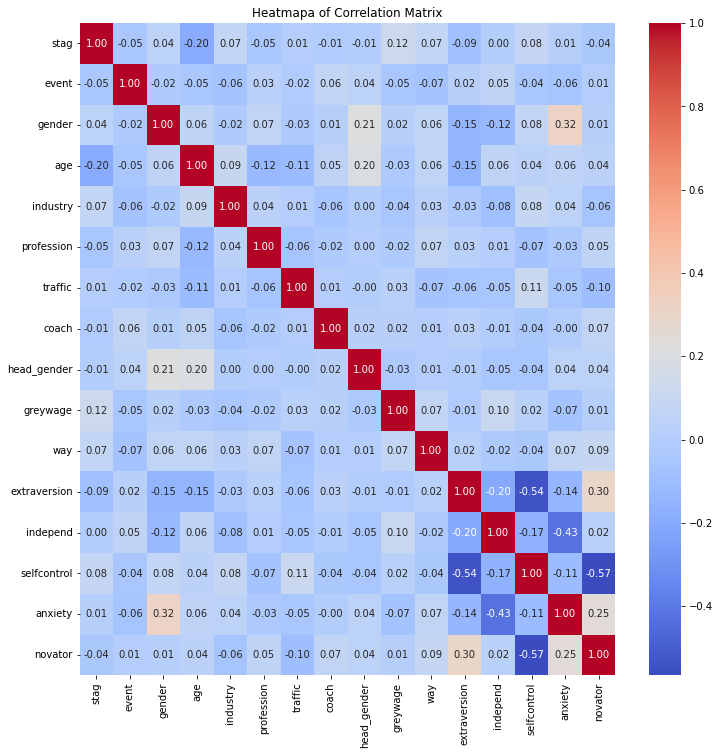

In [31]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmapa of Correlation Matrix')
plt.show()

## **3. Model**

Survival models come in two main flavors, parametric and semi-parametric. In a parametric model, the survival time of a subject is modeled explicitly using a parametric probability distribution. There is a great deal of flexibility in how the parametric probability distribution is constructed. Rather than explicitly modeling a parametric survival probability, semi-parametric survival models instead model the relative effect on survival of covariates.

In the Survival Analysis very common behaviour is to analyze influence of the covariates on the model's prediction. In an employee turnover problem, covariates could include a variety of factors that might impact the likelihood of an employee leaving the company, such as employee's age, gender, psycholigical factors and so on.

That is why we decided to create in our project two separate models, parametric and semi-parametric one.

**3.1. Weibull Model without Covariates**

This model only includes the shape parameter ($ k $) and scale parameter ($ \lambda $) of the Weibull distribution. It assumes that the survival times are only influenced by the Weibull distribution parameters and not by any covariates.

The survival function $ S(t) $, probability density function $ f(t | k, \lambda) $ and the hazard function $ h(t) $ for the Weibull distribution without covariates are:

$ f(t | k, \lambda) = \frac{k}{\lambda} \left(\frac{t}{\lambda}\right)^{k-1} e^{-\left(\frac{t}{\lambda}\right)^k} $

$ S(t | k, \lambda) = e^{-\left(\frac{t}{\lambda}\right)^{k}} $

$ h(t | k, \lambda) = \frac{k}{\lambda}\left(\frac{t}{\lambda}\right)^{k - 1} $

**Parameters**

- $ k $: Shape parameter
- $ \lambda $: Scale parameter

**Required Data**

- $ \text{target} $: Survival times (continuous)
- $ \text{censor} $: Censoring indicators (0 for observed, 1 for censored)


**3.2. Weibull Model with Covariates**

This model includes the shape parameter ($ k $), the scale parameter ($ \lambda $), and the regression coefficients ($ \theta $). It assumes that the survival times are influenced not only by the Weibull distribution parameters but also by covariates.

In this model, the scale parameter $ \lambda $ is modified by the covariates through a linear predictor $ \eta $:

$ \eta = X \theta $

where $ X $ is the matrix of covariates and $ \theta $ is the vector of regression coefficients. The survival, probability density and hazard functions become:

$ \lambda_i = e^{X_i \theta} $

$ S(t_i | k, \lambda_i) = e^{-\left(\frac{t_i}{\lambda_i}\right)^{k}} $

$ f(t_i | k, \lambda_i) = \frac{k}{\lambda_i} \left(\frac{t_i}{\lambda_i}\right)^{k-1} e^{-\left(\frac{t_i}{\lambda_i}\right)^k} $

$ h(t_i | k, \lambda_i) = \frac{k}{\lambda_i}\left(\frac{t_i}{\lambda_i}\right)^{k - 1} $

**Parameters**

- $ k $: Shape parameter
- $ \theta $: Regression coefficients (vector of length $ M $, where $ M $ is the number of covariates)

**Required Data**

- $ X $: Covariate matrix (dimensions $ N \times M $)
- $ \text{target} $: Survival times (continuous)
- $ \text{censor} $: Censoring indicators (0 for observed, 1 for censored)


## **4. Priors**

**4.1. Prior model**

Because of the fact that in the weibull distribution $ \lambda \in (0, +\infty) \land k \in (0, +\infty) $, we set lower limit for $ k $ and $ \lambda $ to $ 0 $. We also choose normal distribution to sample its values depending on the provided mean and standard deviation. ## 4. Priors

```stan
data {
    int <lower=0> N; // number of observations

    real <lower=0> mu_k;          // mean for k
    real <lower=0> sigma_k;       // std for k
    real <lower=0> mu_lambda;     // mean for lambda
    real <lower=0> sigma_lambda;  // std for lambda
}

generated quantities {
    real <lower=0> lambda = normal_rng(mu_lambda, sigma_lambda);
    real <lower=0> k = normal_rng(mu_k, sigma_k);
    array [N] real y_sim; // simulated survival times
    for (n in 1:N) {
        y_sim[n] = weibull_rng(k, lambda);
    }
}
```

In [32]:
def do_sampling(
    model_path: str,
    data: dict,
    target: np.ndarray,
    censor: np.ndarray,
    iter_sampling: int
) -> CmdStanModel:
    
    stan_model = CmdStanModel(stan_file=model_path)
    samples = stan_model.sample(
        data=data,
        fixed_param=True,
        iter_sampling=iter_sampling,
        iter_warmup=1,
        chains=1
    )
    times_sim = samples.stan_variable("y_sim")

    plt.hist(target[censor == 0], bins=30, color="green", edgecolor='black')
    plt.hist(times_sim[-1], bins=30, color="blue", edgecolor='black')
    plt.title(f'Histogram of times sampled using {model_path.split("/")[-1].split(".")[0]}')
    plt.xlabel('Time')
    plt.legend(["Times of observed events", "Times simulated"])
    plt.show()
    
    return samples

In [33]:
target_array, censor_array = df["stag"].values, np.array(1 - df["event"].values)

print(f"Target array shape: {target_array.shape}")
print(f"Censor array shape: {censor_array.shape}")

Target array shape: (1129,)
Censor array shape: (1129,)


**4.2. Parameter values explanation**

While specifying parameters values we should take a look at our historical data. We can see at the times histogram shown below that the historical data suggest, that turnover decreases with employee tenure, so in our priors predictive model we should keep $ k > 1.0 $.

Based on the definition of Weibull distribution parameters, we set the $ k $ mean value $ \mu_k = 1.5 $ with standard deviation $ \sigma_k = 0.1 $.

In our first try we are using $ \mu_\lambda = 1 $ and $ \sigma_\lambda = 0.1 $ for the scale parameter $ \lambda $ as we do not want to scale our characteristic for now.

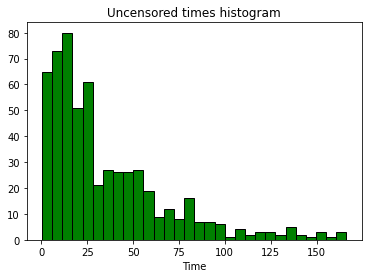

In [34]:
plt.hist(target_array[censor_array == 0], bins=30, color="green", edgecolor='black')
plt.title('Uncensored times histogram')
plt.xlabel('Time')
plt.show()

INFO:cmdstanpy:compiling stan file /home/employee-turnover/stan/prior_parameters.stan to exe file /home/employee-turnover/stan/prior_parameters
INFO:cmdstanpy:compiled model executable: /home/employee-turnover/stan/prior_parameters
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


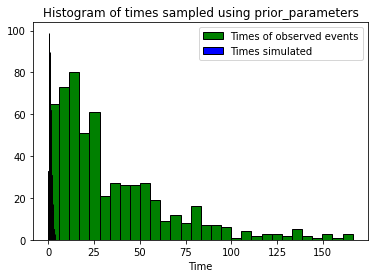

In [35]:
prior_for_parameters_model = do_sampling(
    model_path="stan/prior_parameters.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        
        "mu_k": 1.5,
        "sigma_k": 0.1,
        "mu_lambda": 1,
        "sigma_lambda": 0.1
    },
    target=target_array,
    censor=censor_array,
    iter_sampling=1
)

**4.3. Prior predictive check for parameters**

Based on the received results we can say that the slope of histogram is much larger than in case of our historical data. To fix it we should definitely modify the shape parameter. We can increase the $ \mu_k $ value to $ 0.9 $.

We can also see that the `Time` axis is much wider than in case of our historical data, so to fix that we can increase the scale parameter value to $\mu_\lambda = 20 $. 

We should also modify $ \sigma_k = 0.01 $ and $ \sigma_\lambda = 0.01 $ to decrease ouliers.

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


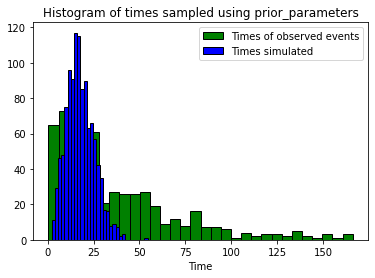

In [36]:
prior_for_parameters_model = do_sampling(
    model_path="stan/prior_parameters.stan",
    data={
        "N": normalized_features_matrix.shape[0],
            
        "mu_k": 2.5,
        "sigma_k": 0.01,
        "mu_lambda": 20,
        "sigma_lambda": 0.01
    },
    target=target_array,
    censor=censor_array,
    iter_sampling=1
)

**4.4. Prior predictive check for measurement**

Having the parameters specified empirically, we can now focus on the prior predictive check for measurement. For that purpose we have to add a new variable to our prior model. The variable represents measurement features (covariates) matrix. We also need to add the theta ($ \theta $) parameter that will represent regression coefficient.

```stan
data {
    int <lower=0> N; // number of observations
    int <lower=0> M; // number of features
    matrix [N, M] X; // covariates matrix

    real <lower=0> mu_k;          // mean for k
    real <lower=0> sigma_k;       // std for k
    real <lower=0> mu_theta;      // mean for theta
    real <lower=0> sigma_theta;   // std for theta
}

generated quantities {
    real <lower=0> k = normal_rng(mu_k, sigma_k);   // shape parameter
    vector <lower=0> [M] theta;                     // regression coefficient
    for (m in 1:M) {
        theta[m] = normal_rng(mu_theta, sigma_theta);
    }
    array [N] real y_sim; // simulated survival times
    for (n in 1:N) {
        y_sim[n] = weibull_rng(k, exp(X[n] * theta));
    }
}
```

INFO:cmdstanpy:compiling stan file /home/employee-turnover/stan/prior_measurements.stan to exe file /home/employee-turnover/stan/prior_measurements


INFO:cmdstanpy:compiled model executable: /home/employee-turnover/stan/prior_measurements
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


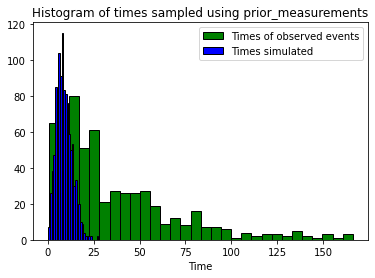

In [37]:
prior_for_measurement_model = do_sampling(
    model_path="stan/prior_measurements.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        "M": normalized_features_matrix.shape[1],
        "X": normalized_features_matrix,
        
        "mu_k": 2.5,
        "sigma_k": 0.01,
        # "mu_lambda": 20,
        # "sigma_lambda": 0.01,
        "mu_theta": 1,
        "sigma_theta": 0.01
    },
    target=target_array,
    censor=censor_array,
    iter_sampling=1
)

In case of priors for measurements, we can see that the shape parameter needs to be changed. It happens because of the fact that for each record we are multiplying the measurements record by the vector of sampled $ k $. Because of that we reduced shape parameter mean to $ \mu_k = 0.5 $.

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


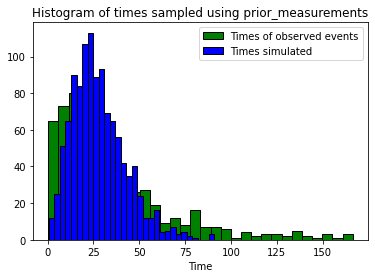

In [38]:
prior_for_measurement_model = do_sampling(
    model_path="stan/prior_measurements.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        "M": normalized_features_matrix.shape[1],
        "X": normalized_features_matrix,
        
        "mu_k": 2.5,
        "sigma_k": 0.01,
        # "mu_lambda": 20,
        # "sigma_lambda": 0.01,
        "mu_theta": 1.5,
        "sigma_theta": 0.01
    },
    target=target_array,
    censor=censor_array,
    iter_sampling=1
)

## 5. Posterior analysis of the first model

```stan
data {
    int <lower=0> N; // number of observations
    vector[N] y;     // survival times
    array[N] int <lower=0,upper=1> censor;  //censoring indicator

    real <lower=0> mu_k;          // mean for k
    real <lower=0> sigma_k;       // std for k
    real <lower=0> mu_lambda;     // mean for lambda
    real <lower=0> sigma_lambda;  // std for lambda
}

parameters {
    real <lower=0> k;       // shape parameter
    real <lower=0> lambda;  // scale parameter
}

model {
    k ~ lognormal(mu_k, sigma_k);
    lambda ~ lognormal(mu_lambda, sigma_lambda);
    for (n in 1:N) {
        if (censor[n] == 0) {
            target += weibull_lpdf(y[n] | k, lambda);
        } else {
            target += weibull_lccdf(y[n] | k, lambda);
        }
    }
}

generated quantities {
    array [N] real y_sim;   // survival times
    vector[N] log_lik;      // likelihood
    for (n in 1:N) {
        if (censor[n] == 0) {
            log_lik[n] = weibull_lpdf(y[n] | k, lambda);
        } else {
            log_lik[n] = weibull_lccdf(y[n] | k, lambda);
        }
        y_sim[n] = weibull_rng(k, lambda);
    }
}
```

INFO:cmdstanpy:compiling stan file /home/employee-turnover/stan/posterior_model_1.stan to exe file /home/employee-turnover/stan/posterior_model_1
INFO:cmdstanpy:compiled model executable: /home/employee-turnover/stan/posterior_model_1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


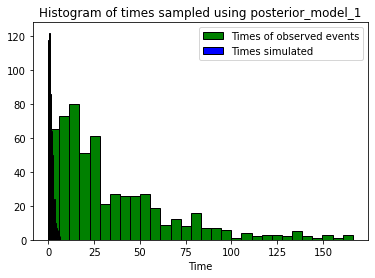

In [39]:
posterior_model_1 = do_sampling(
    model_path="stan/posterior_model_1.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        "M": normalized_features_matrix.shape[1],
        "X": normalized_features_matrix,
        "y": target_array,
        "censor": censor_array,
        
        "mu_k": 2.5,
        "sigma_k": 0.01,
        "mu_lambda": 20,
        "sigma_lambda": 0.01
    },
    target=target_array,
    censor=censor_array,
    iter_sampling=1000
)

## 6. Posterior analysis of the second model

```stan
data {
    int <lower=0> N; // number of observations
    int <lower=0> M; // number of features
    matrix [N, M] X; // covariates matrix
    vector[N] y;     // survival times
    array[N] int <lower=0,upper=1> censor;  //censoring indicator

    real <lower=0> mu_k;          // mean for k
    real <lower=0> sigma_k;       // std for k
    real <lower=0> mu_theta;      // mean for theta
    real <lower=0> sigma_theta;   // std for theta
}

parameters {
    real<lower=0> k;              // shape parameter
    vector <lower=0> [M] theta;   // regression coefficient
}

model {
    k ~ lognormal(mu_k, sigma_k);
    theta ~ lognormal(mu_theta, sigma_theta);
    for (n in 1:N) {
        if (censor[n] == 0) {
            target += weibull_lpdf(y[n] | k, exp(X[n] * theta));
        } else {
            target += weibull_lccdf(y[n] | k, exp(X[n] * theta));
        }
    }
}

generated quantities {
    array [N] real y_sim;   // survival times
    vector[N] log_lik;      // likelihood
    for (n in 1:N) {
        if (censor[n] == 0) {
            log_lik[n] = weibull_lpdf(y[n] | k, exp(X[n] * theta));
        } else {
            log_lik[n] = weibull_lccdf(y[n] | k, exp(X[n] * theta));
        }
        y_sim[n] = weibull_rng(k, exp(X[n] * theta));
    }
}
```

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


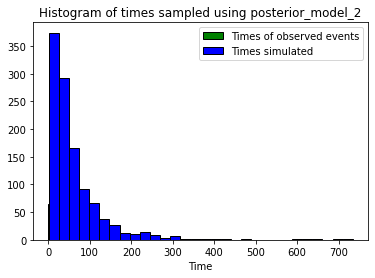

In [40]:
posterior_model_2 = do_sampling(
    model_path="stan/posterior_model_2.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        "M": normalized_features_matrix.shape[1],
        "X": normalized_features_matrix,
        "y": target_array,
        "censor": censor_array,
        
        "mu_k": 2.5,
        "sigma_k": 0.01,
        # "mu_lambda": 20,
        # "sigma_lambda": 0.01,
        "mu_theta": 1.5,
        "sigma_theta": 0.01
    },
    target=target_array,
    censor=censor_array,
    iter_sampling=1000
)

## 7. Model comparison

In [41]:
az_data1 = az.from_cmdstanpy(posterior=posterior_model_1)
az_data2 = az.from_cmdstanpy(posterior=posterior_model_2)

In [42]:
az_data1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [43]:
az_data2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

**Widely Applicable Information Criterion**

In [44]:
model_dict = {"Model 1:":az_data1, "Model 2":az_data2}
model_comp = az.compare(model_dict, ic='waic', scale="deviance")
model_comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 2,0,7877.406141,1.530361e-27,0.000000,0.988449,252.358540,0.000000,False,deviance
Model 1:,1,134069.030980,4.277690e-25,126191.624839,0.011551,4617.025823,4526.123994,False,deviance


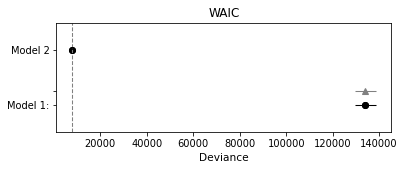

In [45]:
az.plot_compare(model_comp)
plt.title("WAIC")
plt.show()

**Leave-one-out Cross Validation**

model_comp = az.compare(model_dict, ic='loo', scale="deviance")
model_comp

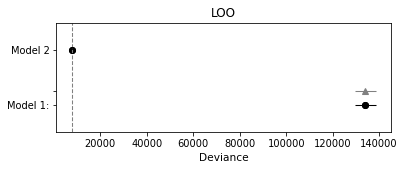

In [46]:
az.plot_compare(model_comp)
plt.title("LOO")
plt.show()